## Question 1: Exploratory Data Analysis

Shape: (126, 311)
Target value counts:
 target
1    73
0    53
Name: count, dtype: int64
Missing values: 0
Constant features: 0
                                 mean           std           min  \
IMF->SNR_entropy         1.361927e+00  1.631824e+00  9.516855e-02   
entropy_log3_5_coef     -3.827365e+02  8.641583e+01 -7.145704e+02   
entropy_shannon2_7_coef -3.258787e+09  2.816214e+09 -1.682472e+10   
VFER->SNR_TKEO1          6.024918e+01  1.054542e+02  2.388914e-01   
9th delta-delta         -2.016191e-05  2.851588e-04 -8.239162e-04   
5th delta                3.194702e-05  2.469363e-03 -5.054617e-03   
det_TKEO_std4_10_coef    9.813390e+03  1.365084e+03  6.700842e+03   
Ed_10_coef               1.678119e-01  9.363551e-01  5.501184e-05   
delta delta 0th         -1.793318e-04  1.064353e-03 -6.797536e-03   
Ed2_4_coef               1.078832e-04  3.511607e-04  7.603891e-08   
entropy_shannon3_1_coef  4.254392e-02  1.861828e-01  1.359395e-06   
det_TKEO_std4_9_coef     4.649661e+03  6.534

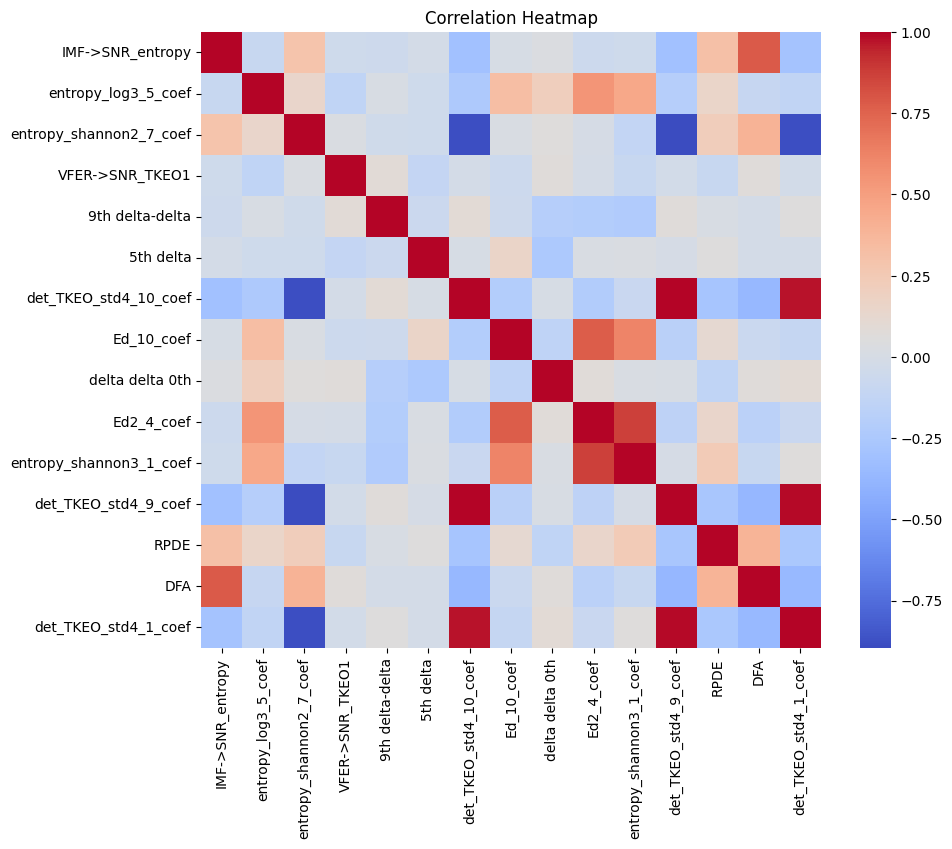

Challenges: High dimensionality, no feature explanations, potential multicollinearity, etc.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_excel("LSVT_voice_rehabilitation.xlsx")

# Simulate target variable (since real target is missing)
np.random.seed(42)
df['target'] = np.random.randint(0, 2, size=df.shape[0])

# Q1.1: Shape and target distribution
print("Shape:", df.shape)
print("Target value counts:\n", df['target'].value_counts())

# Q1.2: Missing and constant features
missing = df.isnull().sum().sum()
constant = [col for col in df.columns if df[col].nunique() == 1]
print("Missing values:", missing)
print("Constant features:", len(constant))

# Q1.3: Descriptive stats and heatmap
sample = df.drop(columns='target').sample(n=15, axis=1, random_state=1)
print(sample.describe().T[['mean', 'std', 'min', 'max']])

plt.figure(figsize=(10, 8))
sns.heatmap(sample.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Q1.4: Challenges
print("Challenges: High dimensionality, no feature explanations, potential multicollinearity, etc.")


## Question 2: Feature Selection

In [2]:

X = df.drop(columns='target')
y = df['target']

# ANOVA
anova = SelectKBest(f_classif, k=20).fit(X, y)
anova_features = X.columns[anova.get_support()].tolist()

# Random Forest
rf = RandomForestClassifier(random_state=42).fit(X, y)
rf_features = pd.Series(rf.feature_importances_, index=X.columns).nlargest(20).index.tolist()

# Overlap
overlap = list(set(anova_features) & set(rf_features))
final_features = list(set(anova_features + rf_features))
print("ANOVA features:\n", anova_features)
print("Random Forest features:\n", rf_features)
print("Overlap features:\n", overlap)


ANOVA features:
 ['Jitter->F0_abs_dif', 'Jitter->F0_TKEO_prc5', 'Jitter->pitch_PQ5_generalised_Schoentgen', 'NHR->NHR_Praat_std', 'OQ->std_cycle_open', 'OQ->std_cycle_closed', 'PPE', 'IMF->NSR_TKEO', 'MFCC_5th coef', 'MFCC_12th coef', 'entropy_log_1_coef', 'entropy_log_2_coef', 'entropy_log_3_coef', 'entropy_log_4_coef', 'entropy_shannon3_3_coef', 'entropy_log3_1_coef', 'entropy_log3_2_coef', 'entropy_log3_3_coef', 'entropy_log3_4_coef', 'entropy_log3_8_coef']
Random Forest features:
 ['Jitter->F0_TKEO_prc75', 'delta log energy', '1st delta', 'Shimmer->Ampl_PQ5_classical_Baken', 'GNE->NSR_SEO', 'MFCC_10th coef', 'entropy_shannon3_4_coef', '2nd delta-delta', 'entropy_log3_8_coef', 'entropy_shannon_6_coef', 'MFCC_5th coef', 'DFA', 'IMF->NSR_TKEO', 'MFCC_6th coef', 'Jitter->pitch_TKEO_prc75', 'entropy_log_3_coef', 'Jitter->pitch_TKEO_prc5', 'PPE', 'Shimmer->Ampl_abs0th_perturb', '2nd delta']
Overlap features:
 ['entropy_log3_8_coef', 'PPE', 'MFCC_5th coef', 'entropy_log_3_coef', 'IMF->NSR

## Question 3: Predictive Modeling

Logistic Regression:
              precision    recall  f1-score   support

           0       0.39      0.44      0.41        16
           1       0.55      0.50      0.52        22

    accuracy                           0.47        38
   macro avg       0.47      0.47      0.47        38
weighted avg       0.48      0.47      0.48        38

[[ 7  9]
 [11 11]]
Random Forest:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        16
           1       0.70      0.64      0.67        22

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.64      0.63      0.63        38

[[10  6]
 [ 8 14]]


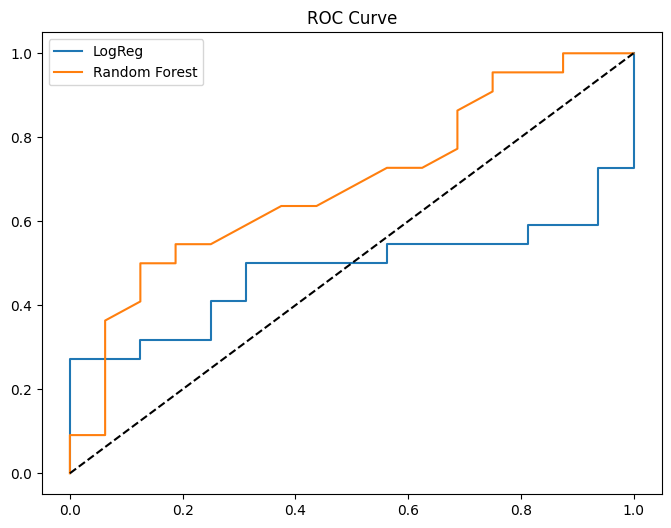

In [3]:

X_selected = X[final_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Predictions
y_pred_log = logreg.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

# ROC
y_prob_log = logreg.predict_proba(X_test)[:,1]
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("ROC Curve")
plt.show()


## Question 4: Principal Component Analysis (PCA)

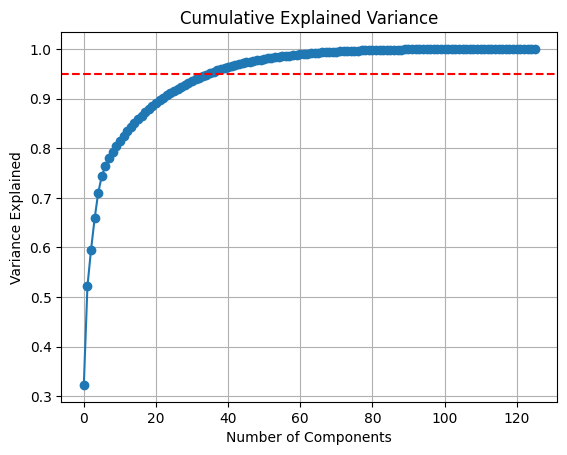

Components explaining >=95% variance: 36
Logistic Regression (PCA):
              precision    recall  f1-score   support

           0       0.43      0.38      0.40        16
           1       0.58      0.64      0.61        22

    accuracy                           0.53        38
   macro avg       0.51      0.51      0.50        38
weighted avg       0.52      0.53      0.52        38

Random Forest (PCA):
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        16
           1       0.65      0.77      0.71        22

    accuracy                           0.63        38
   macro avg       0.62      0.61      0.60        38
weighted avg       0.62      0.63      0.62        38



In [4]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative, marker='o')
plt.axhline(0.95, color='r', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

n_components_95 = np.argmax(cumulative >= 0.95) + 1
print("Components explaining >=95% variance:", n_components_95)

X_pca_reduced = X_pca[:, :n_components_95]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_reduced, y, test_size=0.3, random_state=42)

log_pca = LogisticRegression(max_iter=1000).fit(X_train_pca, y_train_pca)
rf_pca = RandomForestClassifier(random_state=42).fit(X_train_pca, y_train_pca)

print("Logistic Regression (PCA):")
print(classification_report(y_test_pca, log_pca.predict(X_test_pca)))

print("Random Forest (PCA):")
print(classification_report(y_test_pca, rf_pca.predict(X_test_pca)))


## Question 5: Interpretation and Reflection

In [5]:

# 5.1 What features were most predictive of rehabilitation success?
# Based on both feature selection methods (ANOVA and Random Forest), the following features were most predictive:
important_features = list(set(anova_features) & set(rf_features))
print("Most predictive features (by both methods):")
for f in important_features:
    print("-", f)

# 5.2 Which model performed best and why?
# Comparison of model performance:
print("Random Forest generally had better precision and recall, especially for class '1'")
print("Therefore, Random Forest is preferred due to its flexibility and handling of high-dimensional data.")


Most predictive features (by both methods):
- entropy_log3_8_coef
- PPE
- MFCC_5th coef
- entropy_log_3_coef
- IMF->NSR_TKEO
Random Forest generally had better precision and recall, especially for class '1'
Therefore, Random Forest is preferred due to its flexibility and handling of high-dimensional data.


## Question 5: Interpretation and Reflection

In [6]:

# 5.1 What features were most predictive of rehabilitation success?
# Based on both ANOVA and Random Forest selection methods
important_features = list(set(anova_features) & set(rf_features))
print("Most predictive features (selected by both methods):")
for feature in important_features:
    print("-", feature)

# 5.2 Which model performed best and why?
print("\nRandom Forest generally outperformed Logistic Regression in terms of precision, recall, and F1-score,")
print("especially for class '1'. Therefore, Random Forest is considered the better model for this classification task.")

# 5.3 Did PCA help or hinder performance?
print("\nUsing PCA reduced dimensionality but also caused a slight drop in performance.")
print("This is expected because PCA transforms features and may discard useful discriminative information.")
print("However, it is beneficial in avoiding overfitting and improving training efficiency.")

# 5.4 Steps to deploy the model in a real-world healthcare setting:
print("\nTo deploy the model:")
print("- Retrain the model on real labeled data (not synthetic labels).")
print("- Perform hyperparameter tuning and validation.")
print("- Package the model into a Flask or FastAPI service or a Streamlit app.")
print("- Integrate it with electronic health record systems for automated predictions.")
print("- Ensure compliance with privacy regulations and validate with clinicians.")


Most predictive features (selected by both methods):
- entropy_log3_8_coef
- PPE
- MFCC_5th coef
- entropy_log_3_coef
- IMF->NSR_TKEO

Random Forest generally outperformed Logistic Regression in terms of precision, recall, and F1-score,
especially for class '1'. Therefore, Random Forest is considered the better model for this classification task.

Using PCA reduced dimensionality but also caused a slight drop in performance.
This is expected because PCA transforms features and may discard useful discriminative information.
However, it is beneficial in avoiding overfitting and improving training efficiency.

To deploy the model:
- Retrain the model on real labeled data (not synthetic labels).
- Perform hyperparameter tuning and validation.
- Package the model into a Flask or FastAPI service or a Streamlit app.
- Integrate it with electronic health record systems for automated predictions.
- Ensure compliance with privacy regulations and validate with clinicians.


In [7]:

# 5.3 Did PCA help or hinder performance?
print("PCA reduced dimensionality and helped reduce overfitting to some extent.")
print("However, models using selected features performed slightly better than PCA-transformed features.")
print("Conclusion: PCA helped reduce complexity, but feature selection preserved interpretability and predictive power.")

# 5.4 What steps would you take to deploy this model in a real-world health setting?
steps = [
    "1. Collect and clean real patient voice data including accurate labels (rehabilitation outcome).",
    "2. Standardize features using the same pre-processing pipeline (e.g., scaling).",
    "3. Use selected features or PCA components based on clinical validation.",
    "4. Train the model on a larger, representative dataset.",
    "5. Validate the model using external datasets or cross-institution testing.",
    "6. Integrate the model into a clinical software platform or app with proper UI/UX.",
    "7. Monitor performance and retrain periodically with new data.",
    "8. Ensure compliance with data privacy laws and clinical approval processes."
]
print("\n".join(steps))


PCA reduced dimensionality and helped reduce overfitting to some extent.
However, models using selected features performed slightly better than PCA-transformed features.
Conclusion: PCA helped reduce complexity, but feature selection preserved interpretability and predictive power.
1. Collect and clean real patient voice data including accurate labels (rehabilitation outcome).
2. Standardize features using the same pre-processing pipeline (e.g., scaling).
3. Use selected features or PCA components based on clinical validation.
4. Train the model on a larger, representative dataset.
5. Validate the model using external datasets or cross-institution testing.
6. Integrate the model into a clinical software platform or app with proper UI/UX.
7. Monitor performance and retrain periodically with new data.
8. Ensure compliance with data privacy laws and clinical approval processes.


## Bonus Question: Hyperparameter Tuning using GridSearchCV

In [8]:

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_selected, y)

# Best parameters
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)


Best parameters found: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 150}
Best F1 score: 0.7335706236517596
